In [1]:
import finesse
from finesse.analysis.actions import GetErrorSignals, CheckLinearity, RunLocks, DragLocks
from finesse.analysis.actions import SensingMatrixDC, OptimiseRFReadoutPhaseDC
from finesse.analysis.actions.locks import SetLockGains
finesse.configure(plotting=True)

kat = finesse.Model()
kat.parse(
    """
    # Adding a laser and modulator for use in
    # Pound-Drever-Hall-like signals.
    l L0 P=1
    s l_mod1 L0.p1 eo1.p1
    mod eo1 10M 0.1

    s s0 eo1.p2 BS.p1
    bs BS R=0.5 T=0.5

    # North Arm
    s s1 BS.p2 NI.p1
    m NI R=0.99 T=0.01 Rc=1429 phi=90
    s CAV NI.p2 NE.p1 L=10
    m NE R=0.991 T=0.009 Rc=1430 phi=90

    #East Arm
    s s2 BS.p3 EI.p1
    m EI R=0.99 T=0.01 Rc=1429 phi=0
    s CAV2 EI.p2 EE.p1 L=10
    m EE R=0.991 T=0.009 Rc=1430 phi=0

    dof NEz NE.dofs.z +1
    dof EEz EE.dofs.z +1
    dof NIz NI.dofs.z +1

    readout_rf rd_pdh1 NI.p1.o f=10M
    readout_rf rd_pdh2 EI.p1.o f=10M
    readout_rf rd_DF BS.p4.o f=10M

    # Two locks to put the cavities in resonance, and
    # one to move to the dark fringe.
    lock cav1_lock rd_pdh1.outputs.I NEz.DC 1 1e-9
    lock cav2_lock rd_pdh2.outputs.I EEz.DC 1 1e-9
    lock DF_lock rd_DF.outputs.I NIz.DC 1 1e-9

    cav cav1 NI.p2.o
    cav cav2 EI.p2.o
    modes(maxtem=5)
    """
)

In [2]:
kat.NEz.DC += 0.01
kat.EEz.DC += 0.001

In [3]:
sol_errs = kat.run(GetErrorSignals("cav1_lock", "DF_lock"))
print("Initial Error Signals:", sol_errs.results, end="\n\n")

Initial Error Signals: [-1.91529891e-03 -3.68269613e-11]



In [4]:
sol_phases = kat.run(OptimiseRFReadoutPhaseDC("NEz", "rd_pdh1",
                                              "EEz", "rd_pdh2"))
print("Optimal Readout Phases:", sol_phases.phases, end="\n\n")

Optimal Readout Phases: {'rd_pdh1': 179.83322009259226, 'rd_pdh2': 179.83321345335276}



In [5]:
kat.run(SetLockGains(optimize_phase=True))

<SeriesSolution of series @ 0x7e49a1ae38f0 children=0>

In [6]:
sol_matrix = kat.run(SensingMatrixDC(["NEz", "EEz", "NIz"],
                                     ["rd_pdh1", "rd_pdh2", "rd_DF"]))
print("Sensing Matrix:", sol_matrix, end="\n\n", sep="\n")

Sensing Matrix:
┌─────╥───────────┬───────────┬───────────┬───────────┬──────────┬──────────┐
│     ║ rd_pdh1_I │ rd_pdh1_Q │ rd_pdh2_I │ rd_pdh2_Q │ rd_DF_I  │ rd_DF_Q  │
╞═════╬═══════════╪═══════════╪═══════════╪═══════════╪══════════╪══════════╡
│ NEz ║      0.19 │  -3.2E-10 │         0 │         0 │ -1.1E-08 │ -1.1E-08 │
├─────╫───────────┼───────────┼───────────┼───────────┼──────────┼──────────┤
│ EEz ║         0 │         0 │      0.19 │   4.9E-10 │  4.8E-09 │  1.1E-08 │
├─────╫───────────┼───────────┼───────────┼───────────┼──────────┼──────────┤
│ NIz ║     -0.19 │   5.8E-10 │         0 │         0 │ -1.2E-06 │  1.4E-08 │
└─────╨───────────┴───────────┴───────────┴───────────┴──────────┴──────────┘




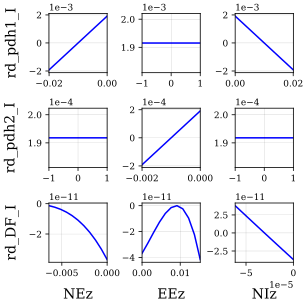

<CheckLinearitySolution of run locks @ 0x7e49a1b70ef0 children=0>

In [7]:
kat.run(CheckLinearity(plot_results=True))

In [8]:
kat.run(RunLocks(method="newton",
                                     display_progress=False,
                                     max_iterations=100,
                                     optimize_phase=True,
                                     scale_factor=1))
print()

In [9]:
print("Results of dragging locks:")
kat.run(DragLocks(method="newton",
                                      parameters=["NE.Rcx"],
                                      stop_points=[1.8],
                                  relative=True,
                                      max_iterations=100))

Results of dragging locks:


<RunLocksSolution of run locks @ 0x7e49a1aaa7b0 children=0>